In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("data/data_stocks.csv")

In [3]:
print(data.shape)
data.head()

(41266, 502)


,DATE,SP500,NASDAQ.AAL,NASDAQ.AAPL,NASDAQ.ADBE,NASDAQ.ADI,NASDAQ.ADP,NASDAQ.ADSK,NASDAQ.AKAM,NASDAQ.ALXN,...,NYSE.WYN,NYSE.XEC,NYSE.XEL,NYSE.XL,NYSE.XOM,NYSE.XRX,NYSE.XYL,NYSE.YUM,NYSE.ZBH,NYSE.ZTS
0,1491226200,2363.6101,42.3300,143.6800,129.6300,82.040,102.2300,85.2200,59.760,121.52,...,84.370,119.035,44.40,39.88,82.03,7.36,50.22,63.86,122.000,53.350
1,1491226260,2364.1001,42.3600,143.7000,130.3200,82.080,102.1400,85.6500,59.840,121.48,...,84.370,119.035,44.11,39.88,82.03,7.38,50.22,63.74,121.770,53.350
2,1491226320,2362.6799,42.3100,143.6901,130.2250,82.030,102.2125,85.5100,59.795,121.93,...,84.585,119.260,44.09,39.98,82.02,7.36,50.12,63.75,121.700,53.365
3,1491226380,2364.3101,42.3700,143.6400,130.0729,82.000,102.1400,85.4872,59.620,121.44,...,84.460,119.260,44.25,39.99,82.02,7.35,50.16,63.88,121.700,53.380
4,1491226440,2364.8501,42.5378,143.6600,129.8800,82.035,102.0600,85.7001,59.620,121.60,...,84.470,119.610,44.11,39.96,82.03,7.36,50.20,63.91,121.695,53.240


In [4]:
data.drop(["DATE"], axis=1, inplace=True)
n = data.shape[0]
data = data.values # data is now a numpy array
data

array([[2363.6101,   42.33  ,  143.68  , ...,   63.86  ,  122.    ,
          53.35  ],
       [2364.1001,   42.36  ,  143.7   , ...,   63.74  ,  121.77  ,
          53.35  ],
       [2362.6799,   42.31  ,  143.6901, ...,   63.75  ,  121.7   ,
          53.365 ],
       ...,
       [2470.03  ,   44.74  ,  164.01  , ...,   76.88  ,  114.31  ,
          62.685 ],
       [2471.49  ,   44.71  ,  163.88  , ...,   76.83  ,  114.23  ,
          62.6301],
       [2471.49  ,   44.74  ,  163.98  , ...,   76.81  ,  114.28  ,
          62.68  ]])

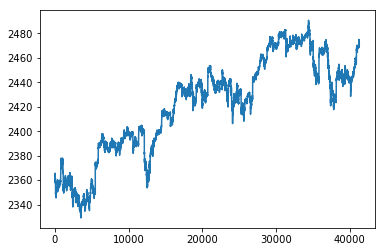

In [5]:
plt.plot(data[:, 0])
plt.show() # SP500 column

In [6]:
n = data.shape[0]
train_data = data.copy()[:int(n*.8), :]
test_data = data.copy()[int(n*.8):, :]
print(n)
print(train_data.shape[0], ", " + str(train_data.shape[0] / n) + " of n.")
print(test_data.shape[0], ", " + str(test_data.shape[0] / n) + " of n.")

41266
33012 , 0.7999806135801871 of n.
8254 , 0.20001938641981293 of n.


In [7]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize
scaler = MinMaxScaler()
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

X_train = train_data[:, 1:]
y_train = train_data[:, 0]
X_test = test_data[:, 1:]
y_test = test_data[:, 0]

In [8]:
m = int(X_train[1].shape[0])
X = tf.placeholder(dtype=tf.float32, shape=[None, m])
y = tf.placeholder(dtype=tf.float32, shape=[None])

In [9]:
# model architecture
layer_1 = 512
layer_2 = 256
layer_3 = 128
layer_4 = 64
output = 1

In [10]:
from tensorflow.contrib.layers import fully_connected
from tensorflow.contrib.layers import batch_norm

he_init = tf.contrib.layers.variance_scaling_initializer()

with tf.contrib.framework.arg_scope(
    [fully_connected],
    biases_initializer=tf.zeros_initializer(),
    weights_initializer=he_init):
    hidden_1 = fully_connected(X, layer_1, scope="hidden_1")
    hidden_2 = fully_connected(hidden_1, layer_2, scope="hidden_2")
    hidden_3 = fully_connected(hidden_2, layer_3, scope="hidden_3")
    hidden_4 = fully_connected(hidden_3, layer_4, scope="hidden_4")
    out = tf.transpose(fully_connected(hidden_4, output, scope="output", activation_fn=None))

In [11]:
with tf.name_scope("loss"):
    loss = tf.reduce_mean(tf.squared_difference(out, y))

with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

0.00049587595


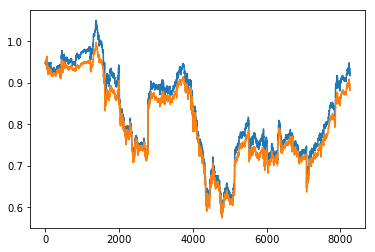

In [12]:
n_epochs = 200
batch_size = 256

def make_random_batches(X, y, batch_size):
    X_batches = []
    y_batches = []
    index = np.random.permutation(len(X))
    curr = 0
    
    while curr < len(X):
        end = min(curr + batch_size, len(X))
        X_batches.append(X[index[curr:end]])
        y_batches.append(y[index[curr:end]])

        curr += batch_size

    return X_batches, y_batches

init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epochs):
        X_batches, y_batches = make_random_batches(X_train, y_train, batch_size)
        
        for X_batch, y_batch in zip(X_batches, y_batches):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})

        if (epoch % 20 == 0):
            pred = sess.run(out, feed_dict={X: X_test})
            axes = plt.gca()
            plt.title("Epoch: " + str(epoch + 20))
            plt.plot(y_test)
            plt.plot(np.transpose(pred))
            file_name = 'img/epoch_' + str(epoch) + '.jpg'
            plt.savefig(file_name)
            plt.cla()
    
    loss_final = sess.run(loss, feed_dict={X: X_test, y: y_test})
    print(loss_final)
    plt.plot(y_test)
    plt.plot(np.transpose(pred))
    plt.show()